In [1]:
# modules importation
from trends_functions import *
import pickle
import os
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.2
sns.set(font_scale=fscale)

In [3]:
# computation parameters
params = get_params()

In [5]:
models = ['GEOS-i33p2_HIST', 'ECHAM6.3-HAM2.3-fSST_HIST' , 'NorESM2-CPL-NEWTEST_HIST']
models = ['NorESM2-CPL-NEWTEST_HIST']
od_vars = ['od550aer', 'od550dust', 'od550ss', 'od550oa', 'od550so4', 'od550bc']
emi_vars = ['emidust', 'emiss', 'emioa', 'emiso4', 'emibc']
varss = od_vars + emi_vars

### compute 5x5 files for each species OD and EMI for some models

In [6]:
for var in varss:
    #get models from params
    params = fill_params(params, var)

    #for the models, set mon_dim to zero
    params['min_dim'] = 0
    mod_var = params['mod_var']

    mod_sources = params['models']
    

    resol = 2
    lons = np.arange(-180, 180, resol)
    lats = np.arange(-90, 90, resol)
    sample_points = [('latitude',lats), ('longitude', lons)]

    MOD_DATA = []
    for model in models:
        print(var,' - ',model)
        params['source'] = model

        #check if model in cache
        fn = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        if os.path.isfile(fn):
            # for reading also binary mode is important 
            pklfile = open(fn, 'rb')      
            mod_data = pickle.load(pklfile) 
            pklfile.close()
        else:
            reader = pya.io.ReadGridded(model)
            mod_data = reader.read_var(mod_var, ts_type='daily')
            mod_data = mod_data.resample_time(to_ts_type='monthly')
            mod_data = mod_data.interpolate(sample_points,scheme='nearest')

            #write picke file in cache directory
            pklfile = open(fn, 'ab') 

            # source, destination 
            pickle.dump(mod_data, pklfile)                      
            pklfile.close()

od550aer  -  NorESM2-CPL-NEWTEST_HIST
od550dust  -  NorESM2-CPL-NEWTEST_HIST
od550ss  -  NorESM2-CPL-NEWTEST_HIST
od550oa  -  NorESM2-CPL-NEWTEST_HIST
od550so4  -  NorESM2-CPL-NEWTEST_HIST
od550bc  -  NorESM2-CPL-NEWTEST_HIST
emidust  -  NorESM2-CPL-NEWTEST_HIST
emiss  -  NorESM2-CPL-NEWTEST_HIST
emioa  -  NorESM2-CPL-NEWTEST_HIST
emiso4  -  NorESM2-CPL-NEWTEST_HIST
emibc  -  NorESM2-CPL-NEWTEST_HIST


### compute trends for each variable

In [7]:
y1, y2 = 2000, 2014

In [8]:
RTRENDS = {}
ATRENDS = {}


for var in varss:
    RTRENDS[var] = {}
    ATRENDS[var] = {}
    
    
    #get models from params
    params = fill_params(params, var)

    #for the models, set mon_dim to zero
    params['min_dim'] = 0
    mod_var = params['mod_var']
    
    for model in models:
        #check if trend is in cache
        fn1 = 'cache/map_trend/rslopes_'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        fn2 = 'cache/map_trend/aslopes_'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        
        if os.path.isfile(fn1) and os.path.isfile(fn2):
            print(var,model,'use pickle',fn1)
            # for reading also binary mode is important 
            pklfile = open(fn1, 'rb')      
            RTRENDS[var][model] = pickle.load(pklfile) 
            pklfile.close()
            # for reading also binary mode is important 
            pklfile = open(fn2, 'rb')      
            ATRENDS[var][model] = pickle.load(pklfile) 
            pklfile.close()
        else:
            print(var,model,'compute trend')
            fn0 = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
            # for reading also binary mode is important 
            pklfile = open(fn0, 'rb')      
            mod_data = pickle.load(pklfile) 
            pklfile.close()

            #average model data per year
            mod_data = mod_data.resample_time(to_ts_type='yearly')

            #initialize empty trends
            rslopes = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))
            aslopes = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))
            pvals = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))
            rslopes[:] = np.nan
            aslopes[:] = np.nan
            pvals[:] = np.nan
            
            for ilat in np.arange((np.shape(mod_data)[1])):
                print(ilat,'/',np.shape(mod_data)[1], end="\r")
                for ilon in np.arange((np.shape(mod_data)[2])):
                    x = np.array([int(str(date)[0:4]) for date in mod_data.time_stamps()])
                    y = np.array(mod_data.data[:,ilat,ilon])

                    #get indexes within period
                    iok = [i for i, year in enumerate(x) if year>=y1 and year<=y2]
                    x = x[iok]
                    y = y[iok]

                    if len(x)>2:
                        trend = compute_lin_trend(x, y, params)
                        rslopes[ilat, ilon] = trend[params['period']]['rel_slp']
                        aslopes[ilat, ilon] = trend[params['period']]['a']
                        pvals[ilat, ilon] = trend[params['period']]['pval']
            
            RTRENDS[var][model] = rslopes
            ATRENDS[var][model] = aslopes
            
            #writes pickle file
            pklfile = open(fn1, 'ab') 
            # source, destination 
            pickle.dump(rslopes, pklfile)                      
            pklfile.close()
            
            #writes pickle file
            pklfile = open(fn2, 'ab') 
            # source, destination 
            pickle.dump(aslopes, pklfile)                      
            pklfile.close()
            

od550aer NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550aer-2x2.pkl
od550dust NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550dust-2x2.pkl
od550ss NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550ss-2x2.pkl
od550oa NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550oa-2x2.pkl
od550so4 NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550so4-2x2.pkl
od550bc NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550bc-2x2.pkl
emidust NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_emidust-2x2.pkl
emiss NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_emiss-2x2.pkl
emioa NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_emioa-2x2.pkl
emiso4 NorESM2-CPL-

### get also data for computing time series

In [9]:
DATA = {}
for var in varss:
    DATA[var] = {}
    
    #get models from params
    params = fill_params(params, var)

    for model in models:
        fn0 = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        # for reading also binary mode is important 
        pklfile = open(fn0, 'rb')      
        mod_data = pickle.load(pklfile) 
        pklfile.close()

        #average model data per year
        mod_data = mod_data.resample_time(to_ts_type='yearly')
        DATA[var][model] = mod_data

### make some statistics

In [10]:
#pick one color per species from palette
palette = sns.color_palette("deep", 18)

colors = {
    'od550aer': (0, 0, 0),
    'od550dust': palette[1],
    'od550ss': palette[0],
    'od550so4': palette[3],
    'od550oa': palette[2],
    'od550bc': palette[7],
    'emidust': palette[1],
    'emiss': palette[0],
    'emiso4': palette[3],
    'emioa': palette[2],
    'emibc': palette[7]
}

In [13]:
slp = 'rel' # 'rel' 'abs'
models = ['NorESM2-CPL-NEWTEST_HIST']

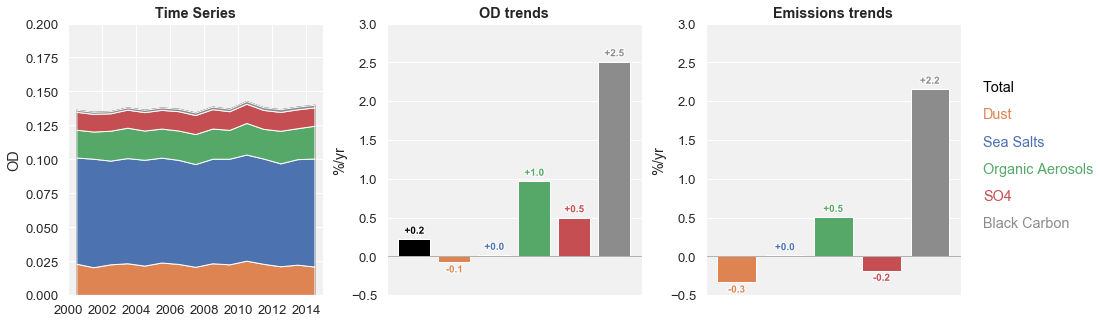

In [22]:
import matplotlib.patheffects as PathEffects

fs = 0.8
nl, nc = len(models), 3
fig, axs = plt.subplots(nl, nc, sharex='col', sharey=False, 
                       gridspec_kw={
                           'wspace': 0.25,
                           'hspace': 0.1
                       })
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)

il, ic = 0, 0
for ic, typ in enumerate(['TS', 'OD', 'EMI']):
    for il, model in enumerate(models):
        if nl>1:
            ax = axs[il, ic]
        else:
            ax = axs[ic]
        #setbackground color
        ax.set_facecolor('#F1F1F1')
        
        if typ=='TS':

            #set title
            if il==0:
                ax.set_title('Time Series', fontweight='bold')
                
            #plot time series

            #AOD
            var = 'od550aer'
            AOD = []
            time = DATA[var][model].time_stamps()
            for i in np.arange(np.shape(DATA[var][model].data)[0]):
                AOD.append(np.nanmean(DATA[var][model].data[i,:,:]))
            ax.stackplot(time, AOD, color=colors[var])

            #all species
            OD = []
            od_specs = ['od550dust', 'od550ss', 'od550oa', 'od550so4', 'od550bc']
            for var in od_specs:
                od = []
                for i in np.arange(np.shape(DATA[var][model].data)[0]):
                    od.append(np.nanmean(DATA[var][model].data[i,:,:]))
                OD.append(od)
            ax.stackplot(time, OD, colors=[colors[var] for var in od_specs])
            
            #set time series limits
            ax.set_xlim('2000-01-01','2015-01-01')
            ax.set_ylim(0,0.2)
        
            #set ylabel
            ax.set_ylabel('OD')
            
            if nl>1:
                #write model name
                ax.text(-0.4,0.5,get_all_mods()[model]['name'], rotation=90, fontweight='bold', va='center', fontsize=16, transform=ax.transAxes)
        
        if typ=='OD':
            #set title
            if il==0:
                ax.set_title('OD trends', fontweight='bold')
            
            #plot a horizontal line at the zero value
            ax.axhline(y=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        
            #prepare arrays to be plotted
            od_bars, od_errs, cols, ecols = [], [], [], []
            for i, var in enumerate(od_vars):
                if slp == 'rel':
                    #need to use the absolute trends and the mean at ref
                    val0 = np.nanmean(DATA[var][model][0,:,:].data)
                    od_bars.append(np.nanmean(ATRENDS[var][model])*100/val0)
                    od_errs.append(np.nanstd(ATRENDS[var][model])*100/val0)
                else:
                    od_bars.append(np.nanmean(ATRENDS[var][model]))
                    od_errs.append(np.nanstd(ATRENDS[var][model]))
                    
                cols.append((*colors[var],1))
                ecols.append((*colors[var],0.5))
                
            #plot bars
            ax.bar(np.arange(0,len(od_bars)), od_bars, color=cols, ecolor=ecols, edgecolor='white')
            #add text
            ytxt = 0.3
            for i, bar in enumerate(od_bars):
                if not np.isnan(bar):
                    fw = 'bold'
                    txt = ax.text(i, bar+np.sign(bar)*0.1, '{:+3.1f}'.format(bar), ha='center', va='center',
                            transform=ax.transData, fontsize=10, zorder=100, color=cols[i], rotation = 0, fontweight=fw
                           )
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
            if slp == 'rel':
                #set axis
                ax.set_ylim(-0.5,3)
                #set ylabel
                ax.set_ylabel('%/yr')
            else:
                ax.set_ylabel('/yr')
                ax.set_ylim(-1e-4,3e-4)
            ax.set_xticks([])
            
            
        elif typ=='EMI':
            #set title
            if il==0:
                ax.set_title('Emissions trends', fontweight='bold')
                
            #plot a horizontal line at the zero value
            ax.axhline(y=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        
            #prepare arrays to be plotted
            emi_bars, emi_errs, cols, ecols = [], [], [], []
            for i, var in enumerate(emi_vars):
                if slp == 'rel':
                    #need to use the absolute trends and the mean at ref
                    val0 = np.nanmean(DATA[var][model][0,:,:].data)
                    emi_bars.append(np.nanmean(ATRENDS[var][model])*100/val0)
                    emi_errs.append(np.nanstd(ATRENDS[var][model])*100/val0)
                else:
                    emi_bars.append(np.nanmean(ATRENDS[var][model]))
                    emi_errs.append(np.nanstd(ATRENDS[var][model]))
                cols.append((*colors[var],1))
                ecols.append((*colors[var],0.5))
                
            #plot bars
            ax.bar(np.arange(0,len(emi_bars)), emi_bars, color=cols, ecolor=ecols, edgecolor='white')
            #add text
            ytxt = 0.3
            for i, bar in enumerate(emi_bars):
                if not np.isnan(bar):
                    fw = 'bold'
                    txt = ax.text(i, bar+np.sign(bar)*0.1, '{:+3.1f}'.format(bar), ha='center', va='center',
                            transform=ax.transData, fontsize=10, zorder=100, color=cols[i], rotation = 0, fontweight=fw
                           )
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
            if slp=='rel':
                #set axis
                ax.set_ylim(-0.5,3)
                #set ylabel
                ax.set_ylabel('%/yr')
            else:
                ax.set_ylabel('unit/yr')
                ax.set_ylim(-5e-13,1e-13)
            ax.set_xticks([])

            
        
        il+=1
        if il>=nl:
            il, ic= 0, ic+1


#change size of the figure
# hide tick and tick label of the big axes
plt.tick_params(labelcolor=None, top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Put a legend to the right of the current axis
dy = 0.10
for i, var in enumerate(od_vars):
    if 'aer' in var:
        txt = 'Total'
    elif 'dust' in var:
        txt = 'Dust'
    elif 'ss' in var:
        txt = 'Sea Salts'
    elif 'oa' in var:
        txt = 'Organic Aerosols'
    elif 'so4' in var:
        txt = 'SO4'
    elif 'bc' in var:
        txt = 'Black Carbon'
    
        
    plt.text(1.025,0.75-dy*i, txt, color=colors[var], ha='left')

fx = 1.0
fig.set_size_inches(16*fx,5*len(models)*fx)
plt.savefig('figs/'+slp+'_species_trends.png', dpi=300, bbox_inches='tight')

### If plot only NorESM2, show species directly in the Time Series

0 od550aer
1 od550dust
2 od550ss
3 od550oa
4 od550so4
5 od550bc


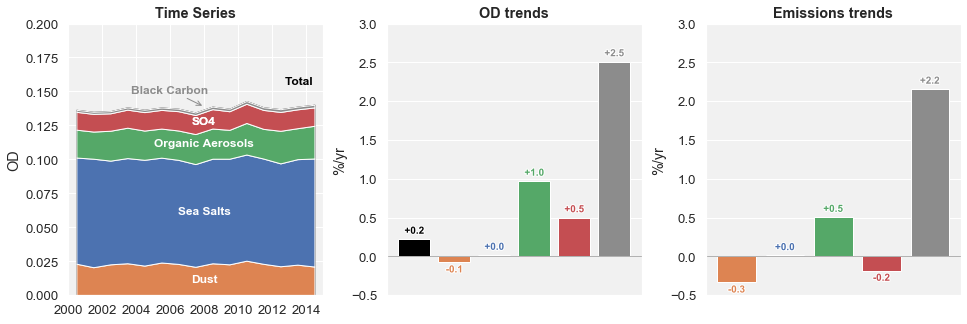

In [68]:
import matplotlib.patheffects as PathEffects

fs = 0.8
nl, nc = len(models), 3
fig, axs = plt.subplots(nl, nc, sharex='col', sharey=False, 
                       gridspec_kw={
                           'wspace': 0.25,
                           'hspace': 0.1
                       })
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)

il, ic = 0, 0
for ic, typ in enumerate(['TS', 'OD', 'EMI']):
    for il, model in enumerate(models):
        if nl>1:
            ax = axs[il, ic]
        else:
            ax = axs[ic]
        #setbackground color
        ax.set_facecolor('#F1F1F1')
        
        if typ=='TS':

            #set title
            if il==0:
                ax.set_title('Time Series', fontweight='bold')
                
            #plot time series

            #AOD
            var = 'od550aer'
            AOD = []
            time = DATA[var][model].time_stamps()
            for i in np.arange(np.shape(DATA[var][model].data)[0]):
                AOD.append(np.nanmean(DATA[var][model].data[i,:,:]))
            ax.stackplot(time, AOD, color=colors[var])

            #all species
            OD = []
            od_specs = ['od550dust', 'od550ss', 'od550oa', 'od550so4', 'od550bc']
            for var in od_specs:
                od = []
                for i in np.arange(np.shape(DATA[var][model].data)[0]):
                    od.append(np.nanmean(DATA[var][model].data[i,:,:]))
                OD.append(od)
            ax.stackplot(time, OD, colors=[colors[var] for var in od_specs])
            
            #set time series limits
            ax.set_xlim('2000-01-01','2015-01-01')
            ax.set_ylim(0,0.2)
        
            #set ylabel
            ax.set_ylabel('OD')
            
            if nl>1:
                #write model name
                ax.text(-0.4,0.5,get_all_mods()[model]['name'], rotation=90, fontweight='bold', va='center', fontsize=16, transform=ax.transAxes)
            
            # Write species in the time series
            for i, var in enumerate(od_vars):
                print(i, var)
                if 'aer' in var:
                    txt = 'Total'
                    x_txt = '2014-01-01' #middle of ts
                    y_txt = AOD[-1]#middle of od
                    ax.text('2014-06-01', y_txt+0.015, txt, color='black', ha='right', fontweight='bold', fontsize=12)
                else:
                    x_txt = '2008-01-01'
                    if 'dust' in var:
                        txt = 'Dust'
                        y_txt = OD[0][8]/2
                    elif 'ss' in var:
                        txt = 'Sea Salts'
                        y_txt = OD[0][8] + OD[1][8]/2
                    elif 'oa' in var:
                        txt = 'Organic Aerosols'
                        y_txt = OD[0][8] + OD[1][8] + OD[2][8]/2
                    elif 'so4' in var:
                        txt = 'SO4'
                        y_txt = OD[0][8] + OD[1][8] + OD[2][8] + OD[3][8]/2 - 0.002
                    t = ax.text(x_txt, y_txt, txt, color='white', ha='center', va='center', fontweight='bold', transform=ax.transData, fontsize=12)
                    #t.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='white')])
                    
                if 'bc' in var:
                    txt = 'Black Carbon'
                    x_txt = '2008-01-01'
                    y_txt = OD[0][8] + OD[1][8] + OD[2][8] + OD[3][8] + OD[4][8]
                    ax.annotate(txt, (x_txt, y_txt), ('2006-01-01',y_txt+0.01), color=colors[var], ha='center', fontweight='bold', arrowprops={'arrowstyle': '->', 'color': colors[var]}, fontsize=12)
                    
            
        
        if typ=='OD':
            #set title
            if il==0:
                ax.set_title('OD trends', fontweight='bold')
            
            #plot a horizontal line at the zero value
            ax.axhline(y=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        
            #prepare arrays to be plotted
            od_bars, od_errs, cols, ecols = [], [], [], []
            for i, var in enumerate(od_vars):
                if slp == 'rel':
                    #need to use the absolute trends and the mean at ref
                    val0 = np.nanmean(DATA[var][model][0,:,:].data)
                    od_bars.append(np.nanmean(ATRENDS[var][model])*100/val0)
                    od_errs.append(np.nanstd(ATRENDS[var][model])*100/val0)
                else:
                    od_bars.append(np.nanmean(ATRENDS[var][model]))
                    od_errs.append(np.nanstd(ATRENDS[var][model]))
                    
                cols.append((*colors[var],1))
                ecols.append((*colors[var],0.5))
                
            #plot bars
            ax.bar(np.arange(0,len(od_bars)), od_bars, color=cols, ecolor=ecols, edgecolor='white')
            #add text
            ytxt = 0.3
            for i, bar in enumerate(od_bars):
                if not np.isnan(bar):
                    fw = 'bold'
                    txt = ax.text(i, bar+np.sign(bar)*0.1, '{:+3.1f}'.format(bar), ha='center', va='center',
                            transform=ax.transData, fontsize=10, zorder=100, color=cols[i], rotation = 0, fontweight=fw
                           )
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
            if slp == 'rel':
                #set axis
                ax.set_ylim(-0.5,3)
                #set ylabel
                ax.set_ylabel('%/yr')
            else:
                ax.set_ylabel('/yr')
                ax.set_ylim(-1e-4,3e-4)
            ax.set_xticks([])
            
            
        elif typ=='EMI':
            #set title
            if il==0:
                ax.set_title('Emissions trends', fontweight='bold')
                
            #plot a horizontal line at the zero value
            ax.axhline(y=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        
            #prepare arrays to be plotted
            emi_bars, emi_errs, cols, ecols = [], [], [], []
            for i, var in enumerate(emi_vars):
                if slp == 'rel':
                    #need to use the absolute trends and the mean at ref
                    val0 = np.nanmean(DATA[var][model][0,:,:].data)
                    emi_bars.append(np.nanmean(ATRENDS[var][model])*100/val0)
                    emi_errs.append(np.nanstd(ATRENDS[var][model])*100/val0)
                else:
                    emi_bars.append(np.nanmean(ATRENDS[var][model]))
                    emi_errs.append(np.nanstd(ATRENDS[var][model]))
                cols.append((*colors[var],1))
                ecols.append((*colors[var],0.5))
                
            #plot bars
            ax.bar(np.arange(0,len(emi_bars)), emi_bars, color=cols, ecolor=ecols, edgecolor='white')
            #add text
            ytxt = 0.3
            for i, bar in enumerate(emi_bars):
                if not np.isnan(bar):
                    fw = 'bold'
                    txt = ax.text(i, bar+np.sign(bar)*0.1, '{:+3.1f}'.format(bar), ha='center', va='center',
                            transform=ax.transData, fontsize=10, zorder=100, color=cols[i], rotation = 0, fontweight=fw
                           )
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
            if slp=='rel':
                #set axis
                ax.set_ylim(-0.5,3)
                #set ylabel
                ax.set_ylabel('%/yr')
            else:
                ax.set_ylabel('unit/yr')
                ax.set_ylim(-5e-13,1e-13)
            ax.set_xticks([])

            
        
        il+=1
        if il>=nl:
            il, ic= 0, ic+1


#change size of the figure
# hide tick and tick label of the big axes
plt.tick_params(labelcolor=None, top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xticks([])
plt.yticks([])

fx = 1.0
fig.set_size_inches(16*fx,5*len(models)*fx)
plt.savefig('figs/'+slp+'_species_trends.png', dpi=300, bbox_inches='tight')